In [1]:
import numpy as np
import pandas as pd
import random
import cvxopt
from cvxopt import matrix, solvers
from cvxopt.modeling import variable
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from libsvm.svmutil import *
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
random.seed(42)

In [2]:
SUBSET = [False,2000] # if True, 2nd val is # of points 
N_FOLDS = 5 # k-Fold cross validation
NUM_FEATURES = 10 # <=25 for the given data
SPLIT = 0.9 # Test-train split (for individual)
MODE = 'LIBSVM' # 'LIBSVM', 'CVXOPT', 'SSMO'
BINARY_CLASSIFICATION = False # Binary classification/Multiclass
C1,C2 = 1,8 # Classes (0-9)
KERNEL = 'LINEAR' # 'LINEAR', 'POLY', 'RBF'
GAMMA = 0.001 # Gamma for RBF Kernel
C = 3.0 # C for L1 regularization
POWER = 2 # Power in Polynomial kernel
COEFF = 4 # Coefficient in Polynomial kernel
MAX_PASSES = 5 # Number of passes in SSMO
TOLERANCE = 1e-3 # Tolerance for SSMO

In [3]:
def getData():
    df = pd.read_csv('2019EE10577.csv',header=None)
    if BINARY_CLASSIFICATION:
        df = df[(df[25] == C1) | (df[25] == C2)]
    dataset = []
    for i,row in df.iterrows():
        xi = []
        for j in range(0,NUM_FEATURES):
            xi.append(row[j])
        if BINARY_CLASSIFICATION:
            if(row[25]==C1):
                xi.append(-1.0)
            else:
                xi.append(1.0)
        else:
            xi.append(row[25])
        dataset.append(xi)
    
    if SUBSET[0]==True:
        dataset = dataset[:SUBSET[1]]
    return dataset

In [4]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [5]:
dataset = getData()

In [6]:
dataset_split = cross_validation_split(dataset)

In [7]:
class SVM:
    def __init__(self,mode='CVXOPT',kernel='LINEAR',C = 3.0,gamma = 0.001, power = 2, coeff = 4, max_passes = 5, tol=1e-3):
        self.mode = mode
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.power = power
        self.coeff = coeff
        self.max_passes = max_passes
        self.tol = tol
    
    def fit(self,X,y):
        X = np.array(X)
        y = np.array(y)
        num_samples,num_features = X.shape
        K = np.zeros((num_samples,num_samples))
        
        for i in (range(num_samples)):
            for j in range(num_samples):
                if self.kernel == 'LINEAR':
                    K[i][j] = np.dot(X[i],np.transpose(X[j]))
                elif self.kernel == 'POLY':
                    K[i][j] = (np.dot(X[i],np.transpose(X[j])) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    K[i][j] = np.exp(-1 * self.gamma*np.sum(np.square(X[i]-X[j])))
        
        self.K = K
        
        if self.mode == 'CVXOPT':
            H = np.zeros((num_samples,num_samples))
            for i in (range(num_samples)):
                for j in range(num_samples):
                    H[i][j] = y[i]*y[j] * K[i][j]
            P = matrix(H)
            q = matrix(np.ones(num_samples) * -1)
            G = matrix(np.vstack(((np.identity(num_samples) * -1),np.identity(num_samples))))
            h = matrix(np.hstack((np.zeros(num_samples),np.ones(num_samples)*self.C)))
            A = matrix(y,(1,num_samples))
            b = matrix(0.0)

            solvers.options['show_progress'] = False
            soln = solvers.qp(P,q,G,h,A,b)
            alpha = np.array(soln['x']) 

            self.sup_idx = np.where(alpha>1e-5)[0]
            self.ind =  np.arange(len(alpha))[self.sup_idx]

            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.b = self.sup_y[0]

            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(self.sup_x[0]))+self.coeff)**self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma*np.sum(np.square(self.sup_x[i]-self.sup_x[0])))
                self.b -= self.alpha[i] * self.sup_y[i] * temp
        
        elif self.mode == 'SSMO':
            alpha = np.zeros((num_samples))
            alpha_old = np.zeros((num_samples))
            E = np.zeros((num_samples))
            b = 0
            passes = 0
            while(passes<self.max_passes):
                num_changed_alpha = 0
                for i in range(num_samples):
                    E[i] = np.sum(alpha * y * self.K[:,i]) + b - y[i]

                    if (y[i] * E[i] < -self.tol and alpha[i]<self.C) or (y[i] * E[i] > self.tol and alpha[i]>0):
                        j = random.randint(0,num_samples-1)
                        while j == i:
                            j = random.randint(0,num_samples-1)

                        E[j] = np.sum(alpha * y * self.K[:,j]) + b - y[j]
                        alpha_old[i] = alpha[i]
                        alpha_old[j] = alpha[j]

                        if y[i] != y[j]:
                            L = max(0,alpha[j] - alpha[i])
                            H = min(self.C,self.C+alpha[j] - alpha[i])
                        else:
                            L = max(0,alpha[i]+alpha[j] - self.C)
                            H = min(self.C,alpha[i] + alpha[j])

                        if L==H:
                            continue

                        eta = 2* self.K[i][j] - self.K[i][i] - self.K[j][j]

                        if eta>=0:
                            continue

                        alpha[j] = alpha[j] - y[j] * (E[i] - E[j])/eta

                        if alpha[j]>H:
                            alpha[j] = H
                        elif alpha[j]<L:
                            alpha[j] = L

                        if abs(alpha[j] - alpha_old[j]) < 1e-5:
                            continue

                        alpha[i] = alpha[i] + y[i]* y[j] * (alpha_old[j] - alpha[j])

                        b1 = b - E[i] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][i] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[i][j]
                        b2 = b - E[j] - y[i] * (alpha[i] - alpha_old[i]) * self.K[i][j] \
                            - y[j] * (alpha[j] - alpha_old[j]) * self.K[j][j] 

                        if 0<alpha[i] and alpha[i] <self.C:
                            b = b1
                        elif 0<alpha[j] and alpha[j] < self.C:
                            b = b2
                        else:
                            b = (b1+b2)/2

                        num_changed_alpha +=1

                if num_changed_alpha == 0:
                    passes+=1
                else:
                    passes=0

            self.b = b
            self.sup_idx = np.where(alpha>0)[0]
            self.sup_x = X[self.sup_idx,:]
            self.sup_y = y[self.sup_idx]
            self.alpha = alpha[self.sup_idx]
            self.w = np.dot(alpha*y,X).T
        
    def predict(self,X):
        preds = []
        for x in X:
            pred = 0
            for i in range(len(self.alpha)):
                if self.kernel == 'LINEAR':
                    temp = np.dot(self.sup_x[i],np.transpose(x))
                elif self.kernel == 'POLY':
                    temp = (np.dot(self.sup_x[i],np.transpose(x)) + self.coeff) ** self.power
                elif self.kernel == 'RBF':
                    temp = np.exp(-1 * self.gamma *np.sum(np.square(self.sup_x[i]-x)))
                pred += self.alpha[i] * self.sup_y[i] * temp
            pred += self.b
            if pred>=0:
                preds.append(1.0)
            else:
                preds.append(-1.0)
        return np.array(preds)

In [8]:
def getAccuracy(preds,testY):
    correct = 0
    for i in range(len(testY)):
        if preds[i] == testY[i]:
            correct +=1
    return correct/len(testY) * 100

In [9]:
def evaluateCrossEval(dataset_split):
    train_acc_list = []
    test_acc_list = []
    for fold in (dataset_split):
        trainDS = list(dataset_split)
        trainDS.remove(fold)
        trainDS = sum(trainDS,[])
        testDS = list()
        
        for row in fold:
            rowCopy = list(row)
            testDS.append(rowCopy)
        
        trainX = [train[:-1] for train in trainDS]
        trainY = [train[-1] for train in trainDS]
        
        testX = [test[:-1] for test in testDS]
        testY = [test[-1] for test in testDS]
        
        if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
            prob = svm_problem(trainY,trainX)
            param = svm_parameter()
            kernel_string_map = {
                'LINEAR': LINEAR,
                'POLY': POLY,
                'RBF': RBF
            }
            param.kernel_type = kernel_string_map[KERNEL]
            param.C = C
            param.gamma = GAMMA
            param.degree = POWER
            param.coef0 = COEFF
            m = svm_train(prob,param,'-q')
            t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
            p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
            train_acc_list.append(t_acc[0])
            test_acc_list.append(p_acc[0])
        else:
            cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
            cf.fit(trainX,trainY)
            
            train_preds = cf.predict(trainX)
            test_preds = cf.predict(testX)
            
            train_acc = getAccuracy(train_preds,trainY)
            test_acc = getAccuracy(test_preds,testY)
            test_acc_list.append(test_acc)
        
    return np.mean(train_acc_list),np.mean(test_acc_list)

In [10]:
evaluateCrossEval(dataset_split)

(85.60833333333332, 83.50000000000001)

In [11]:
# for MODE in ['LIBSVM', 'CVXOPT', 'SSMO']:
#     starttime = datetime.now()
#     _,acc = evaluate(dataset_split)
#     endtime = datetime.now()
#     duration = (endtime-starttime)
#     duration = duration
#     print(MODE,acc,duration)

In [11]:
def evaluateSplit(dataset):
    n = len(dataset)
    trainDS = dataset[:int(SPLIT*n)]
    testDS = dataset[int(SPLIT*n):]
    
    trainX = [train[:-1] for train in trainDS]
    trainY = [train[-1] for train in trainDS]

    testX = [test[:-1] for test in testDS]
    testY = [test[-1] for test in testDS]
    
    if BINARY_CLASSIFICATION == False or MODE == 'LIBSVM':
        prob = svm_problem(trainY,trainX)
        param = svm_parameter()
        kernel_string_map = {
            'LINEAR': LINEAR,
            'POLY': POLY,
            'RBF': RBF
        }
        param.kernel_type = kernel_string_map[KERNEL]
        param.C = C
        param.gamma = GAMMA
        param.degree = POWER
        param.coef0 = COEFF
        m = svm_train(prob,param,'-q')
        t_label, t_acc, t_val = svm_predict(trainY, trainX, m,'-q')
        p_label, p_acc, p_val = svm_predict(testY, testX, m,'-q')
        return _,t_acc[0],p_acc[0]
    else:
        cf = SVM(mode=MODE,kernel=KERNEL,gamma=GAMMA,C=C,power=POWER,coeff=COEFF,max_passes=MAX_PASSES,tol=TOLERANCE)
        cf.fit(trainX,trainY)

        train_preds = cf.predict(trainX)
        test_preds = cf.predict(testX)

        train_acc = getAccuracy(train_preds,trainY)
        test_acc = getAccuracy(test_preds,testY)
        return cf.sup_idx,train_acc,test_acc
    

In [12]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [13]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.533333333333333 11.533333333333335
0.0001 19.408333333333335 18.533333333333335
0.001 77.32499999999999 76.2
0.01 83.1 82.53333333333333
0.1 84.9 83.76666666666668
1.0 85.45000000000002 83.70000000000002
10.0 85.70833333333333 83.43333333333334
100.0 85.775 83.53333333333335


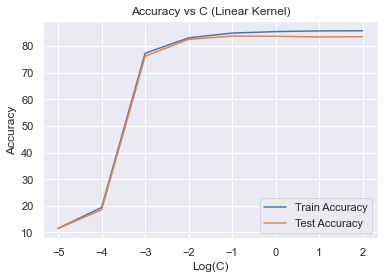

In [14]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()


In [15]:
KERNEL = "RBF"

In [16]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.533333333333333 11.533333333333335
0.0001 11.533333333333333 11.533333333333335
0.001 11.533333333333333 11.533333333333335
0.01 19.39166666666667 19.2
0.1 88.21666666666667 85.53333333333333
1.0 96.5 90.43333333333334
10.0 99.825 90.16666666666666
100.0 100.0 89.76666666666668


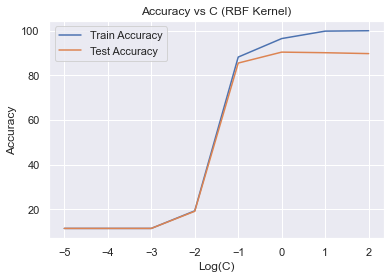

In [17]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [18]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 11.533333333333333 11.533333333333335
0.0001 48.108333333333334 47.233333333333334
0.001 79.84166666666667 79.4
0.01 87.82499999999999 86.53333333333333
0.1 96.5 90.43333333333334
1.0 100.0 46.16666666666667
10.0 100.0 13.566666666666666


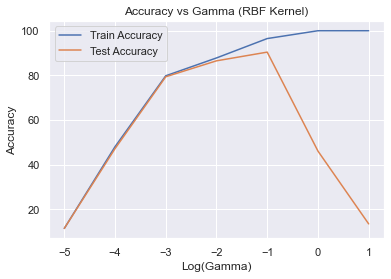

In [19]:
X = [-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [ ]:
# Binary Classification from here:

In [22]:
BINARY_CLASSIFICATION = True
dataset=getData()
dataset_split = cross_validation_split(dataset)

In [24]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [25]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 50.96774193548388 50.96774193548387
0.0001 51.572580645161295 51.77419354838709
0.001 93.99193548387096 94.03225806451613
0.01 95.3225806451613 94.83870967741936
0.1 96.37096774193549 95.0
1.0 96.81451612903227 95.16129032258064
10.0 97.05645161290322 95.16129032258064
100.0 97.01612903225806 95.0
1000.0 97.13709677419355 95.16129032258064


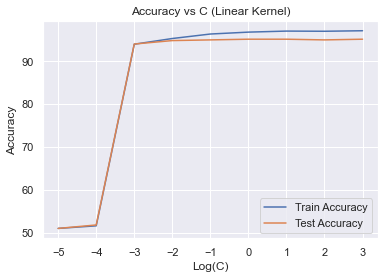

In [26]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()

In [27]:
KERNEL = "RBF"

In [28]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 50.96774193548388 50.96774193548387
0.0001 50.96774193548388 50.96774193548387
0.001 50.96774193548388 50.96774193548387
0.01 88.99193548387096 87.25806451612904
0.1 97.41935483870967 97.09677419354838
1.0 99.4758064516129 98.70967741935483
10.0 99.71774193548387 98.2258064516129
100.0 100.0 98.06451612903226
1000.0 100.0 98.06451612903226


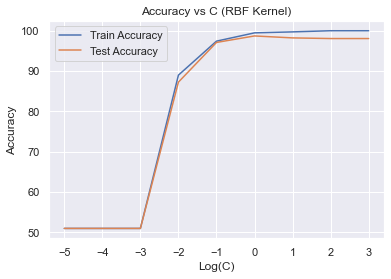

In [29]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [30]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 50.96774193548388 50.96774193548387
1e-05 50.96774193548388 50.96774193548387
0.0001 80.84677419354838 80.32258064516128
0.001 94.75806451612902 95.16129032258064
0.01 97.98387096774192 97.25806451612902
0.1 99.4758064516129 98.70967741935483
1.0 100.0 93.06451612903226
10.0 100.0 64.35483870967741
100.0 100.0 50.96774193548387


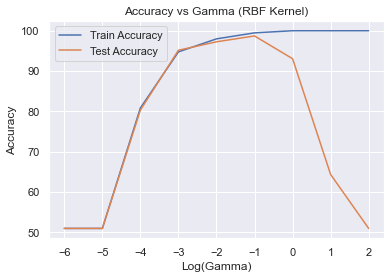

In [31]:
X = [-6,-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [32]:
C1,C2 = 3,7
dataset=getData()
dataset_split = cross_validation_split(dataset)

In [33]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [34]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.10294117647059 44.70588235294118
0.0001 66.69117647058823 61.17647058823529
0.001 96.875 96.61764705882352
0.01 97.68382352941175 97.5
0.1 97.83088235294117 97.35294117647058
1.0 98.125 97.64705882352942
10.0 98.16176470588235 97.79411764705883
100.0 98.16176470588235 97.79411764705883
1000.0 98.16176470588235 97.79411764705883


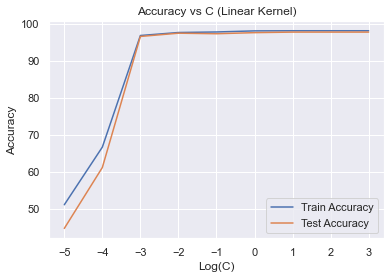

In [35]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()

In [36]:
KERNEL = "RBF"

In [40]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.10294117647059 44.70588235294118
0.0001 51.10294117647059 44.70588235294118
0.001 51.10294117647059 44.70588235294118
0.01 55.69852941176471 48.67647058823529
0.1 98.78676470588236 97.94117647058823
1.0 99.66911764705881 98.23529411764704
10.0 100.0 98.52941176470588
100.0 100.0 98.52941176470588
1000.0 100.0 98.52941176470588


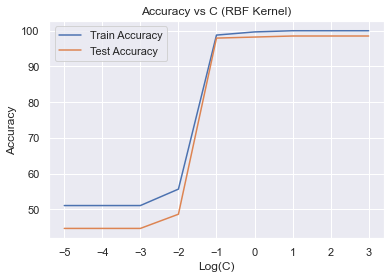

In [41]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [43]:
train_acc_list = []
test_acc_list = []
C = 10
for GAMMA in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 51.10294117647059 44.70588235294118
1e-05 96.36029411764706 96.32352941176472
0.0001 97.20588235294119 96.76470588235294
0.001 97.75735294117648 97.79411764705883
0.01 98.97058823529412 98.23529411764704
0.1 100.0 98.52941176470588
1.0 100.0 82.05882352941175
10.0 100.0 44.70588235294118


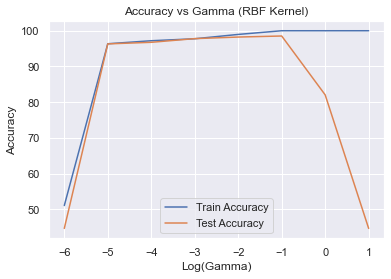

In [44]:
X = [-6,-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()

In [45]:
C1,C2 = 4,9
dataset=getData()
dataset_split = cross_validation_split(dataset)

In [46]:
KERNEL = "LINEAR"
MODE = "LIBSVM"

In [47]:
train_acc_list = []
test_acc_list = []
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.5929203539823 48.14159292035398
0.0001 51.5929203539823 48.14159292035398
0.001 80.70796460176992 78.23008849557523
0.01 85.92920353982302 85.30973451327434
0.1 87.38938053097345 87.0796460176991
1.0 88.14159292035399 86.54867256637169
10.0 88.1858407079646 86.19469026548673
100.0 88.14159292035397 86.3716814159292


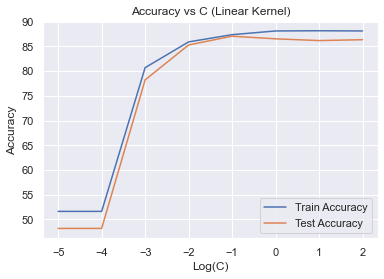

In [48]:
X = [-5,-4,-3,-2,-1,0,1,2]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (Linear Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (Linear Kernel).png',dpi=1200)
plt.show()

In [49]:
KERNEL = "RBF"

In [50]:
train_acc_list = []
test_acc_list = []
#GAMMA = 0.03
GAMMA = 1/(NUM_FEATURES)
for C in [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(C,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-05 51.5929203539823 48.14159292035398
0.0001 51.5929203539823 48.14159292035398
0.001 51.5929203539823 48.14159292035398
0.01 51.5929203539823 48.14159292035398
0.1 86.99115044247789 85.13274336283186
1.0 96.72566371681417 91.85840707964601
10.0 99.55752212389382 90.79646017699115
100.0 100.0 88.84955752212389
1000.0 100.0 88.84955752212389


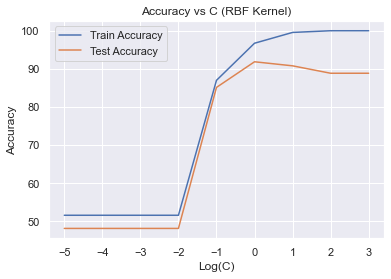

In [51]:
X = [-5,-4,-3,-2,-1,0,1,2,3]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs C (RBF Kernel).png',dpi=1200)
plt.show()

In [52]:
train_acc_list = []
test_acc_list = []
C = 1
for GAMMA in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]:
    train_acc,test_acc = evaluateCrossEval(dataset_split)
    print(GAMMA,train_acc,test_acc)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

1e-06 51.5929203539823 48.14159292035398
1e-05 51.5929203539823 48.14159292035398
0.0001 51.5929203539823 48.14159292035398
0.001 83.8495575221239 82.83185840707964
0.01 88.67256637168143 87.96460176991151
0.1 96.72566371681417 91.85840707964601
1.0 100.0 72.56637168141592
10.0 100.0 48.14159292035398


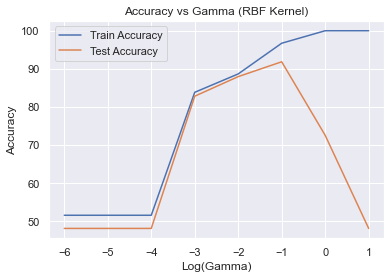

In [53]:
X = [-6,-5,-4,-3,-2,-1,0,1]
plt.plot(X,train_acc_list, label="Train Accuracy")
plt.plot(X,test_acc_list,label="Test Accuracy")
plt.xlabel('Log(Gamma)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma (RBF Kernel)')
plt.legend()
plt.savefig('Plots/Accuracy vs Gamma (RBF Kernel).png',dpi=1200)
plt.show()